In [4]:
#Libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD


In [2]:
# Function to resize and save the images
def resize_and_save_image(input_path, output_path, size):
    img = tf.keras.preprocessing.image.load_img(input_path, target_size=size)
    #img = img.convert("L") #Converts to grayscale
    img.save(output_path)

In [12]:
# Parameters
# Get the current working directory path
current_directory = os.getcwd()

# Create the input_folder path by joining the current directory with the "Original_Images" folder
input_folder = os.path.join(current_directory, 'Original_Images')

output_folder = "Train_Images"
test_folder = "Test_Images"
validation_folder = "Validation_Images"
img_width, img_height = 68, 120
batch_size = 16

# Create subfolders for each class in the output folder
cat_names = [
    'Cabina_c', 'Cabina_Noddi', 'Cabina_Nodri', 'Cabina_Noei', 'Cabina_Nofadi',
    'Cabina_Nofdi', 'Cabina_Noftli', 'Cabina_Nomi', 'Cabina_Nopdi', 'Cabina_Notg'
]

# Create a new folder to store the resized images for training
output_folder_path = os.path.join(os.getcwd(), output_folder)
if os.path.exists(output_folder_path):
    shutil.rmtree(output_folder_path)
os.makedirs(output_folder_path)

# Create a new folder to store the resized images for testing
test_folder_path = os.path.join(os.getcwd(), test_folder)
if os.path.exists(test_folder_path):
    shutil.rmtree(test_folder_path)
os.makedirs(test_folder_path)

# Create a new folder to store the resized images for validation
validation_folder_path = os.path.join(os.getcwd(), validation_folder)
if os.path.exists(validation_folder_path):
    shutil.rmtree(validation_folder_path)
os.makedirs(validation_folder_path)

# Create a list to hold the available image indices
image_indices = list(range(1, 21))

# Resize images and save to the respective class subfolders for training and testing
for cat_name in cat_names:
    # Randomly select 16 images for training
    train_indices = random.sample(image_indices, 16)

    # Create subfolders for each class in the training folder
    cat_output_folder_path = os.path.join(output_folder_path, cat_name)
    os.makedirs(cat_output_folder_path)

    for i in train_indices:
        img_path = os.path.join(input_folder, f"{cat_name}{i}.png")
        output_path = os.path.join(cat_output_folder_path, f"{cat_name}{i}.png")
        resize_and_save_image(img_path, output_path, size=(img_width, img_height))

    # Save the remaining 4 images for testing
    test_indices = [idx for idx in image_indices if idx not in train_indices]

    # Create subfolders for each class in the testing folder
    cat_test_folder_path = os.path.join(test_folder_path, cat_name)
    os.makedirs(cat_test_folder_path)

    for i in test_indices:
        img_path = os.path.join(input_folder, f"{cat_name}{i}.png")
        output_path = os.path.join(cat_test_folder_path, f"{cat_name}{i}.png")
        resize_and_save_image(img_path, output_path, size=(img_width, img_height))
        

# Create subfolders for each class in the last images folder
for cat_name in cat_names:
    cat_folder_path = os.path.join(validation_folder_path, cat_name)
    os.makedirs(cat_folder_path, exist_ok=True)

# Save the last 3 images of each class to the respective class subfolders
for cat_name in cat_names:
    for i in range(21, 24):
        img_path = os.path.join(input_folder, f"{cat_name}{i}.png")
        output_path = os.path.join(validation_folder_path, cat_name, f"{cat_name}{i}.png")
        resize_and_save_image(img_path, output_path, size=(img_width, img_height))


In [601]:
# Define the folders for training and testing data
train_folder = "Train_Images"
test_folder = "Test_Images"

# Use the Keras ImageDataGenerator to load the training and testing data
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

test_generator = train_datagen.flow_from_directory(
    test_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)


Found 160 images belonging to 10 classes.
Found 40 images belonging to 10 classes.


In [602]:
# Define the CNN architecture
model = Sequential()
model = models.Sequential([
    layers.Conv2D(10, (3, 3), padding='same', input_shape=(img_width, img_height, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(20, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(30, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(40, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(50, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

In [603]:
# Define your desired learning rate
learning_rate = 0.04
# Create the optimizer with the desired learning rate
#optimizer = RMSprop(learning_rate=learning_rate)

momentum = 0.9
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

In [604]:
# Compile the model

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create the EarlyStopping callback
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Train the model with early stopping
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=150,
                    verbose=1,
                    #callbacks=[early_stopping]
                    )

Epoch 1/150
10/10 [==============================] - 1s 35ms/step - loss: 3.8413 - accuracy: 0.1312 - val_loss: 875.8718 - val_accuracy: 0.1000
Epoch 2/150
10/10 [==============================] - 0s 28ms/step - loss: 2.5617 - accuracy: 0.1437 - val_loss: 788.0749 - val_accuracy: 0.1000
Epoch 3/150
10/10 [==============================] - 0s 26ms/step - loss: 2.5404 - accuracy: 0.1688 - val_loss: 765.4903 - val_accuracy: 0.1000
Epoch 4/150
10/10 [==============================] - 0s 27ms/step - loss: 2.2887 - accuracy: 0.2250 - val_loss: 447.9538 - val_accuracy: 0.1000
Epoch 5/150
10/10 [==============================] - 0s 26ms/step - loss: 2.2232 - accuracy: 0.2062 - val_loss: 220.4442 - val_accuracy: 0.1000
Epoch 6/150
10/10 [==============================] - 0s 26ms/step - loss: 2.1594 - accuracy: 0.2250 - val_loss: 99.6067 - val_accuracy: 0.1000
Epoch 7/150
10/10 [==============================] - 0s 26ms/step - loss: 2.1235 - accuracy: 0.2438 - val_loss: 63.8343 - val_accuracy: 0

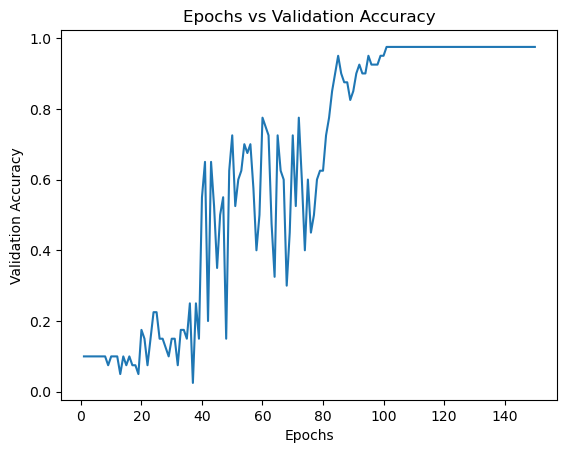

In [605]:
# Get the validation accuracy values from the history
val_accuracy = history.history['val_accuracy']

# Plot the epochs vs validation accuracy
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Epochs vs Validation Accuracy')
plt.show()

In [606]:
# Load the last 3 images of each class for validation
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    validation_folder,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Predict the classes for the validation set
true_labels = validation_generator.classes
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)


# Print true and predicted classes for each image
for i in range(len(true_labels)):
    print("True Class:", cat_names[true_labels[i]])
    print("Predicted Class:", cat_names[predicted_labels[i]])
    print("------")

Found 30 images belonging to 10 classes.
30/30 [==============================] - 0s 2ms/step
True Class: Cabina_c
Predicted Class: Cabina_c
------
True Class: Cabina_c
Predicted Class: Cabina_c
------
True Class: Cabina_c
Predicted Class: Cabina_c
------
True Class: Cabina_Noddi
Predicted Class: Cabina_Noddi
------
True Class: Cabina_Noddi
Predicted Class: Cabina_Noddi
------
True Class: Cabina_Noddi
Predicted Class: Cabina_Noddi
------
True Class: Cabina_Nodri
Predicted Class: Cabina_Nodri
------
True Class: Cabina_Nodri
Predicted Class: Cabina_Nodri
------
True Class: Cabina_Nodri
Predicted Class: Cabina_Nodri
------
True Class: Cabina_Noei
Predicted Class: Cabina_Noei
------
True Class: Cabina_Noei
Predicted Class: Cabina_Noei
------
True Class: Cabina_Noei
Predicted Class: Cabina_Noei
------
True Class: Cabina_Nofadi
Predicted Class: Cabina_Nofadi
------
True Class: Cabina_Nofadi
Predicted Class: Cabina_Nofadi
------
True Class: Cabina_Nofadi
Predicted Class: Cabina_Nofadi
------


In [607]:
# Calculate accuracy
accuracy = sum(true_labels == predicted_labels) / len(true_labels)
print("Accuracy:", accuracy*100, '%')

Accuracy: 100.0 %
